# Choropleth Maps in Plotly (part 2)

### Choropleth 3 - Population Distribution in Powiats

Last choropleth will plot population density in Polish powiats in year 2013. The concept of creating this chart is the same as previous. Unlike the previous choropleths, this one will need more data processing due to bigger number of polygons (powiats). We will also use <code>Mapbox</code> - a mapping platform for custom designed maps.

Data sources [Accessed 27th October 2021]:<br>
https://zpe.gov.pl/a/rozmieszczenie-ludnosci-polski/DQ9OTgf37<br>
https://static.zpe.gov.pl/portal/f/res/R4RyNQv9sF7eC/4/1AjOpiYeZdgfDYu2l5NlhyE7CY6d1QEB/Geog_gim_2_15_4_Gest_zalud_Powiaty.ods

In [1]:
# importing modules
import pandas as pd
import plotly.express as px

In [2]:
# geojson with powiats
url = r'https://raw.githubusercontent.com/ppatrzyk/polska-geojson/master/powiaty/powiaty-medium.geojson'

# loading geojson data from url
from urllib.request import urlopen
import json

with urlopen(url) as response:
    pow_url = json.load(response)

# check properties for any element
pow_url['features'][3]['properties']

{'id': 4, 'nazwa': 'powiat radomski'}

In [3]:
# number of features (powiaty) in geojson - there should be 380 for Poland
n = len(pow_url['features'])
n

380

In [4]:
# get list of powiats
powiats = []

for i in range(0,n):
    powiats.append(pow_url['features'][i]['properties']['nazwa'])

# display first 10 elements
powiats[0:10]

['powiat ropczycko-sędziszowski',
 'powiat łosicki',
 'powiat piaseczyński',
 'powiat radomski',
 'powiat sierpecki',
 'powiat szydłowiecki',
 'powiat węgrowski',
 'powiat gostyniński',
 'powiat grodziski',
 'powiat łukowski']

In [5]:
# number of unique values
b = len(set(powiats))

# difference between list length and unique values
print(n - b)

# return duplicates from list of powiats
print(set([x for x in powiats if powiats.count(x) > 1]))

10
{'powiat średzki', 'powiat opolski', 'powiat nowodworski', 'powiat ostrowski', 'powiat tomaszowski', 'powiat grodziski', 'powiat brzeski', 'powiat krośnieński', 'powiat świdnicki', 'powiat bielski'}


Unfortunately, not all names of powiats are unique in Poland which means we will not be able to match their id's correctly with data frame rows by names. There would be 10 missing powiats on future choropleth. Both the data frame and GeoJSON file will need a new unique feature (for example TERYT) to map all powiats.
Since the number of duplicates in not large I downloaded the GeoJSON file from URL location and changed the names manually based on the point coordinates searched on Google Maps and it's voivodeship. Let's load the corrected file from directory.

In [6]:
# loading geojson file from directory
powiaty = json.load(open('powiaty.geojson', encoding='UTF-8'))

# check properties for any element
powiaty['features'][34]['properties']

{'id': 35, 'nazwa': 'powiat mrągowski'}

In [7]:
# loading pandas data
df = pd.read_excel('data_2013.xlsx', header=0, sheet_name='Sheet1')

# adding new column with population density
df['density'] = df['population']/df['area']

# scaling data in new column with log10 - this will improve presentation
from numpy import log10
df['density'] = log10(df['density'])

df.head()

,powiat,area,population,density
0,bolesławiecki,1304,90420,1.840987
1,dzierżoniowski,479,105284,2.342027
2,głogowski,443,90386,2.309697
3,górowski,738,36625,1.695721
4,jaworski,582,52356,1.954043


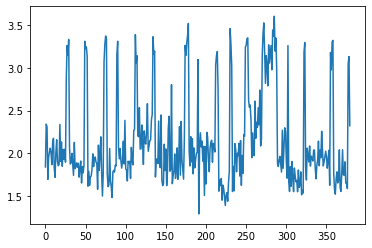

In [8]:
# overall plot on population density
df['density'].plot()

In [9]:
# unique values of powiat names in data frame
print(len(df['powiat'].unique()))

# are lengths equal?
print(len(powiaty['features']) == len(df['powiat']))

380
True


We need to remove "powiat " substring from names in GeoJSON. Otherwise we won't match id's with data frame records. Optionally, we can add this phrase to <code>powiat</code> column in the data frame but it is better to reduce memory usage.

In [10]:
# trim/remove substring 'powiat ' from powiat name
for i in range(0,n):
    if 'nazwa' in powiaty['features'][i]['properties']:
        powiaty['features'][i]['properties']['nazwa'] =\
        powiaty['features'][i]['properties']['nazwa'].replace('powiat ', '')

# check any name from geojson
powiaty['features'][120]['properties']['nazwa']

'garwoliński'

In [11]:
# extracting powiat names and their id's from geojson
pow_id_map = {}

for feature in powiaty['features']:
    feature['id'] = feature['properties']['id']
    pow_id_map[feature['properties']['nazwa']] = feature['id']

# check first 10 elements
list(pow_id_map.items())[0:10]

[('ropczycko-sędziszowski', 1),
 ('łosicki', 2),
 ('piaseczyński', 3),
 ('radomski', 4),
 ('sierpecki', 5),
 ('szydłowiecki', 6),
 ('węgrowski', 7),
 ('gostyniński', 8),
 ('grodziski (mazowiecki)', 9),
 ('łukowski', 10)]

In [12]:
# create new id column in data frame by matching with id from geojson
df['id'] = df['powiat'].apply(lambda x: pow_id_map[x])

df.head()

,powiat,area,population,density,id
0,bolesławiecki,1304,90420,1.840987,150
1,dzierżoniowski,479,105284,2.342027,187
2,głogowski,443,90386,2.309697,36
3,górowski,738,36625,1.695721,313
4,jaworski,582,52356,1.954043,378


In [13]:
# mapbox choropleth
fig_pow = px.choropleth_mapbox(data_frame=df,
                               geojson=powiaty,
                               locations=df['id'],
                               color=df['density'],
                               color_continuous_scale='YlOrRd',
                               range_color=(0,5),
                               mapbox_style='carto-positron',
                               hover_name=df['powiat'],
                               height=900,
                               center={'lat': 52, 'lon': 20},
                               opacity=.4,
                               zoom=5,
                               labels={'density': '[density scale]'},
                               title='Population Density in Poland in 2013')

fig_pow.update_geos(fitbounds='locations', visible=True)

# hide colorbar
fig_pow.update_layout(coloraxis_showscale=False)

import plotly
# save to html file
plotly.offline.plot(fig_pow, filename='figure_density.html')

'figure_density.html'

The choropleth map due to it's size and interactive functions was exported to an HTML file. It can be opened in any web browser and is available in the repository.

### Conclusions

This notebook represented how to efficiently plot choropleth maps with Python on different cases. These figures were made in <code>plotly</code> library which allows us to easily build outline and interactive choropleths. We successfully composed three different thematic maps:
* static, noninteractive choropleth of unemployment rates, 
* animated graph of new cases of COVID-19 per day with time slider,
* interactive choropleth of population density with mapping layout.

Further map customization is possible and it is a matter of individual preferences. These charts represent enough information about spatial variations of a quantity and further styling is not needed. They should be easy to interpretate by any reader. Finally, choropleth maps are great visualization techniques to show clear regional pattern in the data, or for local data.